# Named Entity Recognition with Pytorch

Named entity recognition (NER) is an information extraction task that aims to locate and classify named entities in text. A named entity is a word or group of words that refer a subject by a propoer noun. For instance, in the sentence "John is going to Milan, Italy.", "John" is a named entity for a person and "Milan" and "Italy" are named entities for locations.

NER is an effective tool for extracting key information from large bodies of text. For example, it can help answer questions such as which countries are mentioned in a news article or how many drugs are mentioned in a medical report.

In this notebook, we will demonstrate the task of NER using a simple LSTM architecture. We will use the English subset of the [CoNLL2003](https://www.clips.uantwerpen.be/conll2003/ner/) dataset which contains sentences from Reuters news wire articles.

We load the dataset using the [HuggingFace datasets](https://huggingface.co/datasets/conll2003) library which can be installed as shown below. Each sample is a sentence presented as a list of tokens and a NER tag is provided for every token. This dataset follows the [IOB2](https://arxiv.org/abs/cmp-lg/9505040) tagging format and considers four classes of named entities: person (PER), organization (ORG), location (LOC) and miscellaneous (MISC). Entities that are not named entities are tagged with O.

The IOB2 format adds an "I" or "B" prefix to each tag. The "I" prefix indicates a token that is part of an entity made of multiple tokens. Also, the IOB2 format ignores stopwords between tokens in terms prefix assignment. An example IOB2 tagging is shown below:

*John[B-PER] is[O] going[O] to[O] Milan[B-LOC] ,[O] Italy[I-LOC] .[O]*

This results in 9 total classes including the "O" class.

In the cells below, we load the dataset from the library and then into Pandas DataFrames for ease of manipulation

In [ ]:
!pip install -q datasets

In [ ]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset('conll2003')
train = pd.DataFrame(dataset['train']).drop(columns=['pos_tags', 'chunk_tags']).set_index('id')
val = pd.DataFrame(dataset['validation']).drop(columns=['pos_tags', 'chunk_tags']).set_index('id')
test = pd.DataFrame(dataset['test']).drop(columns=['pos_tags', 'chunk_tags']).set_index('id')

#Named entity class ID mappings (https://huggingface.co/datasets/conll2003)
ner2id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
id2ner = {v: k for k, v in ner2id.items()}

train.head()

Reusing dataset conll2003 (/root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee)


  0%|          | 0/3 [00:00<?, ?it/s]

,tokens,ner_tags
id,,
0,"[EU, rejects, German, call, to, boycott, Briti...","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,"[Peter, Blackburn]","[1, 2]"
2,"[BRUSSELS, 1996-08-22]","[5, 0]"
3,"[The, European, Commission, said, on, Thursday...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,"[Germany, 's, representative, to, the, Europea...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


## Data Preprocessing

The next step is to prepare the data for our model.

We first clean the data by converting all characters to lowercase so that lowercase and uppercase versions of the same word do not get counted as different tokens.

Next, we remove punctuation and non-alphanumeric characters since they do not contribute the the NER task. Also, each of these characters is assigned a NER tag of "O" in the list of NER tags. Therefore, we make sure that these are also removed to maintain a proper alignment between tokens and tags. Also, we find that some samples consisted of punctuation only (like ".") and became empty as a result of deleting punctuation. Therefore, we make sure that these rows are excluded from the DataFrames.

Having cleaned up the text, we need to convert it to a numerical representation to be used by the model. We map each word in the vocabulary of the entire dataset to a unique integer identity. Therefore, each sentence will be represented by a sequence of integers. The overall dataset will be represented by a matrix of dimension (M,N) where M is the number of samples and N is the sequence length (number of words in the sentence). Each scalar in the N-sized vector is an integer representing a word. Since not all sentences have the same length, we pad all shorter sentences by zeros to reach the length of the maximum sentence in the dataset. However, we do this for each batch separately instead of padding to the global maximum sequence lengths since this results in smaller batches of data.

For the procedure described above, we perform the following steps:
- Compile a list of the full dataset vocabulary.
- Create a word to index mapping to assign each word in the vocabulary a unique ID. Note that we start the mapping from 2 since the 0 and 1 indexes are reserved for padding and unknown tokens respectively.
- To do this transformation, we define a function that takes a DataFrame and outputs a matrix where all sentences are padded to the same length and each word is replaced by its corresponding ID.
- We similarly populate a matrix with the NER tags. However, the padding for the labels is done with a value of -1 instead of 0 since the value of 0 is used for the "O" tag. Also, this will allow us to filter out padding tokens when compute the loss and F1 score.

In [ ]:
import torch

#lowercase
train['tokens'] = train['tokens'].apply(lambda x: [w.lower() for w in x])
val['tokens'] = val['tokens'].apply(lambda x: [w.lower() for w in x])
test['tokens'] = test['tokens'].apply(lambda x: [w.lower() for w in x])

#remove punctuation
#it is also important that we remove corresponding ner tags for the removed punctuation tokens
def remove_punc(data):
    punc = """!"#$%&'()*+,-./:;=?@[\]^_`{|}~"""
    for row in data.itertuples():
        punc_idx = [idx for idx, token in enumerate(row.tokens) if token in punc]
        for idx in sorted(punc_idx, reverse=True):
            del data.at[row.Index,'tokens'][idx]
            del data.at[row.Index,'ner_tags'][idx]
remove_punc(train)
remove_punc(val)
remove_punc(test)

#drop empty rows
train = train[train['tokens'].map(bool)]
val = val[val['tokens'].map(bool)]
test = test[test['tokens'].map(bool)]

#build full vocabulary
vocab = []
for row in train.itertuples():
    for word in row.tokens:
        if word not in vocab:
            vocab.append(word)
for row in val.itertuples():
    for word in row.tokens:
        if word not in vocab:
            vocab.append(word)
for row in test.itertuples():
    for word in row.tokens:
        if word not in vocab:
            vocab.append(word)

#word integer encoding
#0 is for padding
#1 is for unknown
word2id = {word: id+2 for id, word in enumerate(sorted(vocab))}
id2word = {id+2: word for id, word in enumerate(sorted(vocab))}

#word index and label matrices
def prepare_batch(data):
    #compute max sentence length for current batch
    max_len = max(len(row.tokens) for row in data.itertuples())
    X = torch.zeros((data.shape[0], max_len))
    y = -1*torch.ones((data.shape[0], max_len))
    for row_index, row in enumerate(data.itertuples()):
        for word_pos, word in enumerate(row.tokens):
            X[row_index, word_pos] = word2id.get(word, 1)
            y[row_index, word_pos] = row.ner_tags[word_pos]
    return X.int(), y.long().view(-1)

In [ ]:
train.head()

,tokens,ner_tags
id,,
0,"[eu, rejects, german, call, to, boycott, briti...","[3, 0, 7, 0, 0, 0, 7, 0]"
1,"[peter, blackburn]","[1, 2]"
2,"[brussels, 1996-08-22]","[5, 0]"
3,"[the, european, commission, said, on, thursday...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,"[germany, 's, representative, to, the, europea...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


## Model Definition

Our model is a simple LSTM that takes as input each sentence as a sequence of words (tokens). Each word is represented by an embedding vector. Word embeddings are learned by an embedding layer during training.

The shape of the embedding matrix is *(number of elements to embed, embedding vector dimension)*. The embedding vector dimension is a hyperparameter that can be tuned. In this case, the number of elements to embed is set to the vocab size (including 0 and 1 tokens) since we need a unique embedding vector for each token in the vocabulary. We also set the argument *padding_idx* to 0 to indicate that tokens of ID 0 are meant for padding and can be ignored when learning the embeddings.

Before passing the output of the embedding layer to the LSTM, we pass it through the "pack_padded_sequence" function. This function packs and batches the data in a way to ignore the zero indexes corresponding to the padding tokens. This results in a considerable computation reduction. To do this, we need to provide the actual length for each sequence (prior to padding). Based on this information, the function will basically sort the samples and divide them into batches based on actual length. For a full explanation of the workings of this function refer to the tutorial [here](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Sequence-Labeling#language-models).

The next layer in our model is an LSTM which consumes the embedding vector and outputs for every sequence:
- The output at each timestep.
- The last hidden state.
- The last cell state.

In this case, we need the output vector at each timestep as an input to a dense softmax classifier to produce a classification for each token. To recover the original format, we use the "pad_packed_sequence" on the LSTM output. This function reverts the manipulation done by "pack_padded_sequence".

Furthermore, the unpacked LSTM output is of shape *(batch_size, sequence_length, hidden_size)*. However, the dense layer expects a 2D input. Therefore we reshape the data to *(batch_size × sequence_length, hidden_size)*.

Finally, the classification layer produces a softmax output using the last hidden state. The diagram below shows the shapes of the word embeddings and the architecture of the model.

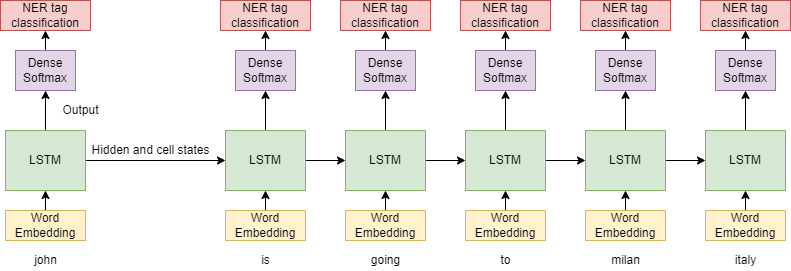

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#define model
class NER(nn.Module):
    def __init__(self, vocab_size, hunits, embed_dim, n_classes, dropout_rate):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hunits, batch_first=True)
        self.out = nn.Linear(hunits, n_classes)
    
    def forward(self, X, lengths):
        X = self.embedding(X) #batch_size, sequence_length, embedding_dim
        X = F.dropout(X, p=self.dropout_rate, training=self.training)
        #pack the sequence to ignore padding tokens
        X = nn.utils.rnn.pack_padded_sequence(X, lengths, batch_first=True, enforce_sorted=False).to(device)
        X, _ = self.lstm(X)
        #unpack the output to retrieve its original shape
        X, _ = nn.utils.rnn.pad_packed_sequence(X, batch_first=True) #batch_size, sequence_length, hidden_dim
        #reshape 
        X = X.reshape(-1, X.shape[2]) #batch_size*sequence_length, hidden_dim
        X = F.dropout(X, p=self.dropout_rate, training=self.training)
        X = self.out(X) #batch_size*sequence_length, num_classes
        return F.log_softmax(X, dim=1)

## Training and validation

We can now proceed to train and validate the model. The code below allows to train in batches to accomodate for memory limitations. We use the categorical crossentropy loss function and the ADAM optimizer.  For our evaluation metric, we use the macro-averaged F1 score.

For every epoch, we record the training loss and F1 score. We also evaluate the model on the validation set after every epoch and also record the loss and F1 score. After the training is finished we plot the training and validation metrics to assess model bias and variance.

When calculating both the loss and the F1 score, it is important to ignore the model outputs for the padding tokens since these are not part of the text and should not be given a NER tag. We do this by exploiting the -1 values we assigned to padding tokens in the labels array. We create a boolean mask for the values in the labels that are greater or equal to zero and use this same mask to filter both the labels and the model outputs.

In [2]:
import numpy as np
x = [
    [1,2,3,-1,-1],
    [6,7,-1,-1,-1],
    [8,9,10,11,12]
]

x = np.asarray(x)

mask = x >= 0
mask

array([[ True,  True,  True, False, False],
       [ True,  True, False, False, False],
       [ True,  True,  True,  True,  True]])

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(41)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#hyperparameters
num_epochs = 12
batch_size = 256
hunits = 128
embedding_dim = 200
dropout_rate = 0.5
lr = 0.003

#calculate number of classes
num_classes = int(np.concatenate(train['ner_tags'].values.tolist()).max()+1)

#model
model = NER(len(vocab)+2, hunits, embedding_dim, num_classes, dropout_rate)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#evaluation function
def evaluate(data, return_out=False):
    X, y = prepare_batch(data)
    X = X.to(device)
    #create mask to exclude pad tokens marked by -1 in the label array
    mask = y >= 0
    #calculate actual lengths (without padding) to use when packing the sequences
    lengths = [len(row.tokens) for row in data.itertuples()]
    with torch.no_grad():
        model.eval()
        out = model(X, lengths).cpu()
        #compute loss while masking out padding tokens
        loss = F.nll_loss(input=out[mask], target=y[mask])
        #compute F1 score while masking out padding tokens
        f1 = f1_score(y[mask], out[mask].argmax(dim=1), average='macro')
    if return_out:
        return loss, f1, out
    else:
        return loss, f1

#training loop
train_losses = []
train_f1s = []
val_losses = []
val_f1s = []
for epoch in range(num_epochs):
    #training
    losses = []
    train_preds = []
    train_targets = []
    model.train()
    for i in range(0, train.shape[0], batch_size):
        X_train_batch, y_train_batch = prepare_batch(train.iloc[i:i+batch_size])
        #create mask to exclude pad tokens marked by -1 in the label array
        mask = y_train_batch >= 0
        train_targets.append(y_train_batch[mask])
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        #calculate actual lengths (without padding) to use when packing the sequences
        lengths = [len(row.tokens) for row in train.iloc[i:i+batch_size].itertuples()]
        optimizer.zero_grad()
        out = model(X_train_batch, lengths)
        #collect predictions excluding padding tokens to calculate the F1 score
        train_preds.append(out[mask].detach().cpu())
        #compute loss while masking out padding tokens
        loss = F.nll_loss(input=out[mask], target=y_train_batch[mask])
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().item())
    train_targets = torch.cat(train_targets)
    train_preds = torch.cat(train_preds)
    f1_train = f1_score(train_targets, train_preds.argmax(dim=1), average='macro')
    train_f1s.append(f1_train)
    train_losses.append(np.mean(losses))
    #validation
    loss_val, f1_val = evaluate(val)
    val_losses.append(loss_val)
    val_f1s.append(f1_val)
    #epoch end
    print(f'********Epoch {epoch+1}********')
    print(f'Train loss: {np.mean(losses):.2f}, Train F1: {f1_train:.2f};    Val loss {loss_val:.2f}, Val F1 {f1_val:.2f}\n')

#training end
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train', 'val'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(train_f1s)
plt.plot(val_f1s)
plt.legend(['train', 'val'])
plt.xlabel('epochs')
plt.ylabel('F1')
plt.show()

## Testing

After obtaining satisfactory results on the validation set, we report the final model performance on the test set. We also plot the confusion matrix to further investigate the model's performance on a per class basis.

Test loss: 0.36, Test F1: 0.66



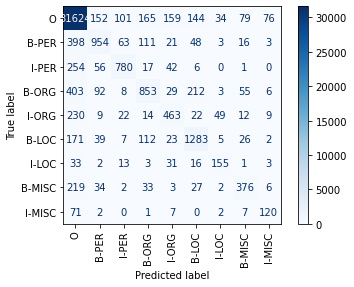

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

loss_test, f1_test, out = evaluate(test, return_out=True)
print(f'Test loss: {loss_test:.2f}, Test F1: {f1_test:.2f}\n')
_, y_test = prepare_batch(test)
mask = y_test >= 0
#compute confusion matrix while masking out padding tokens
ConfusionMatrixDisplay.from_predictions(
    y_test[mask],
    out[mask].argmax(dim=1),
    labels = list(range(num_classes)),
    display_labels = [id2ner[ner] for ner in range(num_classes)],
    cmap='Blues',
    xticks_rotation='vertical'
);